# Scikit-learn Regression-EmissionsHighGranularity Metrics

# Carbon Majors Emissions Dataset

### Dataset Variables
-  **year**: The year of the data point
-  **parent_entity**: The entity to whom the emissions are traced to
-  **parent_type**: The type of parent_entity. Can be one of: investor-owned company, state-owned entity, nation state.
-  **commodity**:Specifies which commodity the production refers to: Oil and NGL, Natural Gas, Anthracite Coal, Bituminous Coal, Lignite Coal, Metallurgical Coal, Sub-Bituminous Coal, Thermal Coal, or Cement.
-  **production_value**: The quantity of production
-  **production_unit**: The unit of production (Oil & NGL - million barrels, Natural Gas - billion cubic feet, Coal - million tonnes, Cement - million tonnes CO2 (see methodology for explanation)). Units - Billion cubic feet per year (Bcf/yr), Million barrels per year (Million bbl/yr), or Million tonnes per year (Million tonnes/yr).
-  **total_emissions_MtCO2e**: 	The total emissions traced to the 'parent_entity' in the 'year'. Units - million tonnes of carbon dioxide equivalent (MtCO2e).

## Model Objective

- Develop a predictive model that estimates total operational emissions (MtCO2e) or total emissions (MtCO2e) based on production volume, commodity type, and other emissions factors.
- Determine how different factors like production value, commodity type (Sub-Bituminous vs. Metallurgical Coal, Natural Gas, Oil &  NGL), and specific emission sources (venting, flaring, fugitive methane, own fuel use, etc.) impact total emissions.
- Forecast future emissions trends based on historical production and emission patterns.

## Import necessary libraries


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from pycaret.datasets import get_data
from imblearn.over_sampling import SMOTE
from sklearn.metrics import mean_squared_log_error

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import learning_curve

from pycaret.regression import * 
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, explained_variance_score

import scipy as sp

import myfuns

## Import Data

In [2]:
# load sample dataset
df=pd.read_csv('emissions_high_granularity.csv')
df.head()

,year,parent_entity,parent_type,reporting_entity,commodity,production_value,production_unit,product_emissions_MtCO2,flaring_emissions_MtCO2,venting_emissions_MtCO2,own_fuel_use_emissions_MtCO2,fugitive_methane_emissions_MtCO2e,fugitive_methane_emissions_MtCH4,total_operational_emissions_MtCO2e,total_emissions_MtCO2e,emissions_category
0,1854,Adaro Energy,Investor-owned Company,Adaro Energy,Sub-Bituminous Coal,50.9000,Million tonnes/yr,92.3401,0.0,0.0,0.0,10.4316,0.3726,10.4316,102.7717,High
1,1855,Adaro Energy,Investor-owned Company,Adaro Energy,Metallurgical Coal,0.9000,Million tonnes/yr,2.3989,0.0,0.0,0.0,0.2710,0.0097,0.2710,2.6700,Low
2,1856,Adaro Energy,Investor-owned Company,Adaro Energy,Sub-Bituminous Coal,48.2300,Million tonnes/yr,87.4963,0.0,0.0,0.0,9.8844,0.3530,9.8844,97.3807,High
3,1857,Adaro Energy,Investor-owned Company,Adaro Energy,Metallurgical Coal,5.7700,Million tonnes/yr,15.3799,0.0,0.0,0.0,1.7375,0.0621,1.7375,17.1174,Low
4,1858,Adaro Energy,Investor-owned Company,Adaro Energy,Sub-Bituminous Coal,52.8073,Million tonnes/yr,95.8002,0.0,0.0,0.0,10.8225,0.3865,10.8225,106.6227,High


## EDA

The complete [y-dat profilling report](https://okerekechisom.github.io/ydata/YDATA%20EmissionsHighGranularity.html)

In [3]:
# check for nulls
df.isna().sum()

year                                  0
parent_entity                         0
parent_type                           0
reporting_entity                      0
commodity                             0
production_value                      0
production_unit                       0
product_emissions_MtCO2               0
flaring_emissions_MtCO2               0
venting_emissions_MtCO2               0
own_fuel_use_emissions_MtCO2          0
fugitive_methane_emissions_MtCO2e     0
fugitive_methane_emissions_MtCH4      0
total_operational_emissions_MtCO2e    0
total_emissions_MtCO2e                0
emissions_category                    0
dtype: int64

In [4]:
df.info()
df.shape

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 169 entries, 0 to 168
Data columns (total 16 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   year                                169 non-null    int64  
 1   parent_entity                       169 non-null    object 
 2   parent_type                         169 non-null    object 
 3   reporting_entity                    169 non-null    object 
 4   commodity                           169 non-null    object 
 5   production_value                    169 non-null    float64
 6   production_unit                     169 non-null    object 
 7   product_emissions_MtCO2             169 non-null    float64
 8   flaring_emissions_MtCO2             169 non-null    float64
 9   venting_emissions_MtCO2             169 non-null    float64
 10  own_fuel_use_emissions_MtCO2        169 non-null    float64
 11  fugitive_methane_emissions_MtCO2e   169 non-n

(169, 16)

## EDA Visualizations

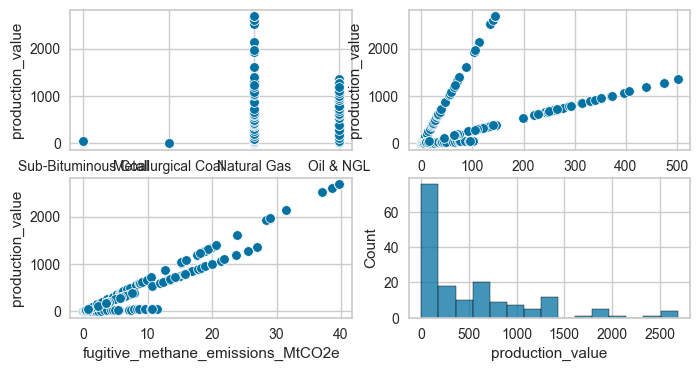

In [5]:
fig,axes = plt.subplots(nrows=2, ncols=2, figsize=(8,4))
sns.scatterplot(data=df, x='commodity', y='production_value', ax=axes[0,0])
sns.scatterplot(data=df, x='product_emissions_MtCO2', y='production_value', ax=axes[0,1])
sns.scatterplot(data=df, x='fugitive_methane_emissions_MtCO2e', y='production_value', ax=axes[1,0])
sns.histplot(df['production_value'],  bins = 15, ax=axes[1,1])

plt.show()

## Prepare the X and y data

- Use one hot encoding for any object or categorical features
- Standardize / Normalize any numeric features

In [6]:
df = df.copy()

In [7]:
X = df.drop(['production_value' ], axis =1)
y = df['production_value']

In [8]:
# one-hot encoding 
X = pd.get_dummies(X, drop_first=True)
X.head()

,year,product_emissions_MtCO2,flaring_emissions_MtCO2,venting_emissions_MtCO2,own_fuel_use_emissions_MtCO2,fugitive_methane_emissions_MtCO2e,fugitive_methane_emissions_MtCH4,total_operational_emissions_MtCO2e,total_emissions_MtCO2e,parent_entity_Adani Enterprises,...,reporting_entity_Abu Dhabi,reporting_entity_Abu Dhabi National Oil Company,reporting_entity_Adani Enterprises,reporting_entity_Adaro Energy,commodity_Natural Gas,commodity_Oil & NGL,commodity_Sub-Bituminous Coal,production_unit_Million bbl/yr,production_unit_Million tonnes/yr,emissions_category_Low
0,1854,92.3401,0.0,0.0,0.0,10.4316,0.3726,10.4316,102.7717,False,...,False,False,False,True,False,False,True,False,True,False
1,1855,2.3989,0.0,0.0,0.0,0.2710,0.0097,0.2710,2.6700,False,...,False,False,False,True,False,False,False,False,True,True
2,1856,87.4963,0.0,0.0,0.0,9.8844,0.3530,9.8844,97.3807,False,...,False,False,False,True,False,False,True,False,True,False
3,1857,15.3799,0.0,0.0,0.0,1.7375,0.0621,1.7375,17.1174,False,...,False,False,False,True,False,False,False,False,True,True
4,1858,95.8002,0.0,0.0,0.0,10.8225,0.3865,10.8225,106.6227,False,...,False,False,False,True,False,False,True,False,True,False


In [9]:
#  Predicting against all data  -basically just drawing a line as we have no test data
full_md1 =LinearRegression()
full_md1.fit(X,y)
y_hat = full_md1.predict(X)
y_hat[:5], y[:5]


(array([50.8316625 , -0.18018907, 48.18099154,  6.87639169, 52.74614023]),
 0    50.9000
 1     0.9000
 2    48.2300
 3     5.7700
 4    52.8073
 Name: production_value, dtype: float64)

## Establish the base units to compare the resultant metrics  ....

In [10]:
df['production_value'].mean(),df['production_value'].median(), df['production_value'].min(),df['production_value'].max(),df['production_value'].max()-df['production_value'].min()


(517.6106414201183, 294.1827, 0.22, 2689.4303, 2689.2103)

In [11]:

   # OR
ymin = np.min(df['production_value'])
ymax = np.max(df['production_value'])
yrange = (np.max(df['production_value']) - np.min(df['production_value']))
ymean= np.mean(df['production_value'])
ymedian=  np.median(df['production_value'])


ymean, ymedian, ymin,ymax,yrange

(517.6106414201183, 294.1827, 0.22, 2689.4303, 2689.2103)

## Create and Fit the Model

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [13]:
X_train.shape, len(X_train)

((118, 22), 118)

In [14]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((118, 22), (51, 22), (118,), (51,))

In [15]:
y_train.value_counts()

production_value
2689.4303    2
29.8607      2
97.3236      2
1277.5000    2
996.9280     1
            ..
20.8000      1
254.2225     1
85.8955      1
145.1240     1
861.6736     1
Name: count, Length: 114, dtype: int64

In [16]:
y_train.value_counts()

production_value
2689.4303    2
29.8607      2
97.3236      2
1277.5000    2
996.9280     1
            ..
20.8000      1
254.2225     1
85.8955      1
145.1240     1
861.6736     1
Name: count, Length: 114, dtype: int64

In [17]:
md1_selected= 'LinearRegression'

In [18]:
# Initialize the LinearRegression model
md1 = LinearRegression(n_jobs=-1)
md1

LinearRegression(n_jobs=-1)

In [19]:
# Train the model
md1.fit(X_train, y_train)

LinearRegression(n_jobs=-1)

## Predict y-hat

In [20]:
# Assigning y_hat variable
y_hat = md1.predict(X_test)
len(y_hat)


51

In [21]:
y_pred = md1.predict(X_train)
y_pred

array([ 9.96937445e+02,  5.86670727e+02,  1.27949652e+03,  4.43184905e+00,
        2.84606847e+02,  4.95639584e+01,  2.66182236e+01,  9.73265098e+01,
        6.95297982e+02,  1.77168486e+01,  2.42936996e+01,  5.27277930e+01,
        6.73827887e+02,  5.56960693e+00,  1.82627541e+00,  2.48260271e+02,
        5.54580954e+02,  1.26962700e+03,  6.66940240e+02,  2.22070312e+01,
        5.08142663e+01,  3.23019881e+02,  3.42615505e+01,  1.27747062e+03,
        3.62419130e+01,  3.02107839e+02,  3.49329010e+01,  2.25072145e+01,
        3.79221498e+01,  1.33056081e+01,  1.12098525e+01,  3.61762248e+02,
        1.45113993e+02,  8.59500984e+01,  2.54185089e+02,  2.08286094e+01,
        4.87932259e+02,  3.29345006e+02,  1.34578227e+01,  1.06860651e+03,
        6.83596421e+02,  4.21871070e+01,  1.99771174e+02,  2.68940669e+03,
        4.71863096e+01,  8.68136771e+00,  9.48239617e+02,  3.16777996e+02,
        1.73929824e+02,  1.27746941e+03,  1.96592000e+03,  1.03200363e+03,
        6.54107447e+02,  

## Evaluating residuals 

In [22]:
eval_df = pd.DataFrame({'Actuals': y_test, 'Preds': y_hat})
eval_df['abs_diff'] = np.abs(eval_df['Actuals'] - eval_df['Preds'])
eval_df['residuals'] = eval_df['Actuals'] - eval_df['Preds']
eval_df.head()

,Actuals,Preds,abs_diff,residuals
138,672.3000,672.367145,0.067145,-0.067145
30,1.4000,1.513520,0.113520,-0.113520
119,117.7125,117.567840,0.144660,0.144660
29,1.0000,1.220262,0.220262,-0.220262
143,708.1000,708.069045,0.030955,0.030955


## Mean Absolute Error (MAE)

In [23]:
# how far off on avg?
mae = mean_absolute_error(y_test, y_hat)
print(f"The MAE of the {md1_selected} model: {mae:.2f} \nUnformated Value: {mae}")

The MAE of the LinearRegression model: 0.06 
Unformated Value: 0.057864218422024764


## Predict Root Mean Squared Error (RMSE)

In [24]:
#  now take into account a few points being far off ....
# RMSE - analogous to std of your predictions...
rmse = np.sqrt(mean_squared_error(y_test, y_hat))
print(f"The RMSE of the {md1_selected} model: {rmse:.2f}\nUnformated Value: {rmse}")

The RMSE of the LinearRegression model: 0.08
Unformated Value: 0.079068170080318


## Coefficient of Determination (R2) and Adjusted-(R2)

In [25]:
# coffiecient of determination
r2 = r2_score(y_test,y_hat)
print( f"The r-squared of the {md1_selected} model: {r2:.2f} \nUnformated value:{r2}")


The r-squared of the LinearRegression model: 1.00 
Unformated value:0.9999999835527777


In [26]:
# Applying my saved function
adj_r2 = myfuns.adj_r2(r2, len(y_test), X_test.shape[1])

print(f"The adjusted r-squared of the {md1_selected} model: {adj_r2:.2f} \nUnformatted value: {adj_r2}")


The adjusted r-squared of the LinearRegression model: 1.00 
Unformatted value: 0.9999999706299603


In [27]:
# Expressing r-squared score as pct of variability explained by the independent variable(s).
print (f"{r2_score(y_test, y_hat)*100:.2f}% of the variabilty in the dependent variable is explained by the independent variable(s).")

100.00% of the variabilty in the dependent variable is explained by the independent variable(s).


## Mean Squared Error

In [28]:
actual_values = eval_df['Actuals']
predicted_values =eval_df['Preds']

In [29]:
# Calculate MSE
mse = mean_squared_error(actual_values , predicted_values)

# Print MSE
print(f"The MSE of the {md1_selected} model: {mae:.2f} \nUnformated Value: {mse}")

The MSE of the LinearRegression model: 0.06 
Unformated Value: 0.006251775519850093


## Root Mean Squared Logarithmic Error (RMSLE)

In [30]:
# Calculate RMSLE
RMSLE = np.sqrt(mean_squared_log_error(actual_values, predicted_values))

# Print MSE
print(f"The RMSLE of the {md1_selected} model: {mae:.2f} \nUnformated Value: {RMSLE}")

The RMSLE of the LinearRegression model: 0.06 
Unformated Value: 0.020236089227208248


## Mean Absolute Percentage Error

In [31]:
# Calculate MAPE
mape = np.mean(np.abs((np.array(actual_values) - np.array(predicted_values)) / np.array(actual_values))) * 100

print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")


Mean Absolute Percentage Error (MAPE): 1.08%


In [32]:
eval_df.describe().T

,count,mean,std,min,25%,50%,75%,max
Actuals,51.0,518.571431,622.666489,0.912500,17.113250,312.732000,718.150000,2689.430300
Preds,51.0,518.559300,622.671261,0.848267,17.071949,312.820248,718.256990,2689.409107
abs_diff,51.0,0.057864,0.054420,0.001279,0.022297,0.049885,0.074253,0.291953
residuals,51.0,0.012132,0.078909,-0.220262,-0.022819,0.021193,0.055022,0.291953


In [33]:
eval_df.mean()

Actuals      518.571431
Preds        518.559300
abs_diff       0.057864
residuals      0.012132
dtype: float64

## Residual Visualizations

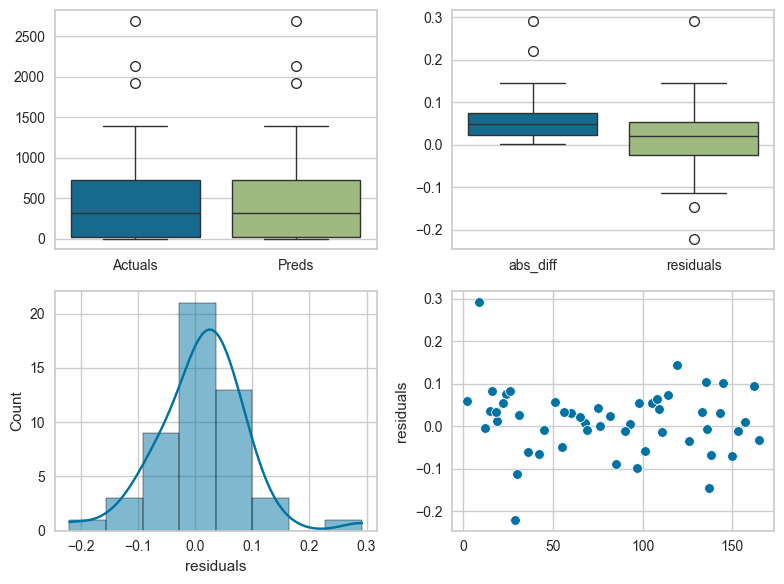

In [34]:
fig,axes = plt.subplots(nrows=2, ncols=2, figsize=(8,6))
sns.boxplot(data=eval_df[['Actuals', 'Preds']], ax=axes[0,0]) 
sns.boxplot(data=eval_df[['abs_diff', 'residuals']], ax=axes[0,1])
sns.histplot(data=eval_df['residuals'], kde=True, bins=8, ax=axes[1,0])
sns.scatterplot(data=eval_df['residuals'], ax=axes[1,1])
 
plt.tight_layout()
plt.show()
 

## Probability Plot/QQ Plot

#### Assumption: the distribuction is normal or near normal

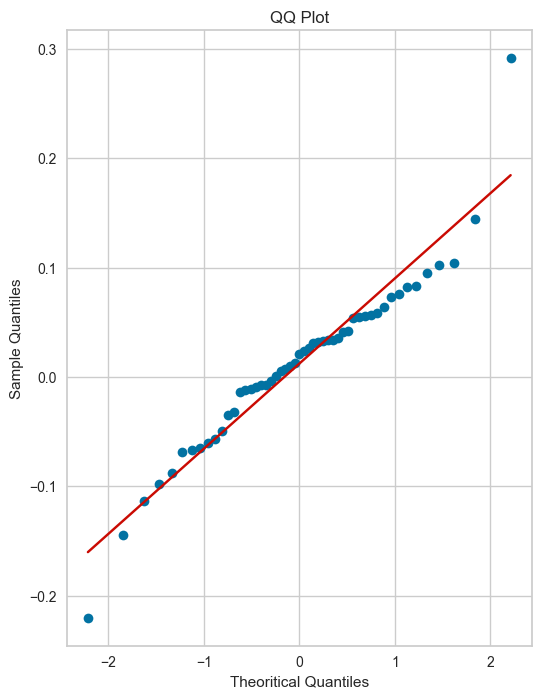

In [35]:
# Need scipy for the probability plot below (optional)

import scipy as sp
 
# probability plot (more stats / R based concept)
fig, ax = plt.subplots(figsize=(6,8))
_ = sp.stats.probplot(eval_df['residuals'],dist ='norm',plot=ax)

# red line represent a perfect normal distribution
ax.set_title('QQ Plot')
ax.set_xlabel('Theoritical Quantiles')
ax.set_ylabel('Sample Quantiles')
plt.show()
 

## Using plot_model function to generate plots individually.

### Prediction error plot

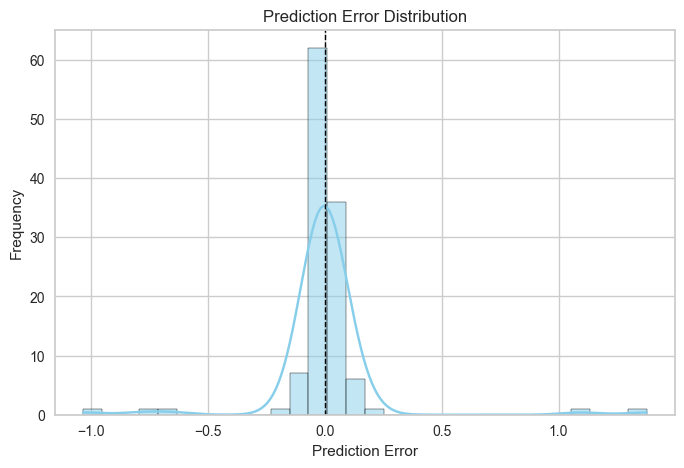

In [36]:
# Calculate the prediction error
prediction_error = y_train - y_pred  

# Create a Seaborn plot for the prediction error
plt.figure(figsize=(8, 5))
sns.histplot(prediction_error, kde=True, color='skyblue', bins=30)  # Use prediction_error here

# Add labels and title
plt.axvline(0, color='black', linestyle='--', linewidth=1)  # Zero reference line
plt.xlabel("Prediction Error")
plt.ylabel("Frequency")
plt.title("Prediction Error Distribution")

plt.show()

## A Learning Curve plot

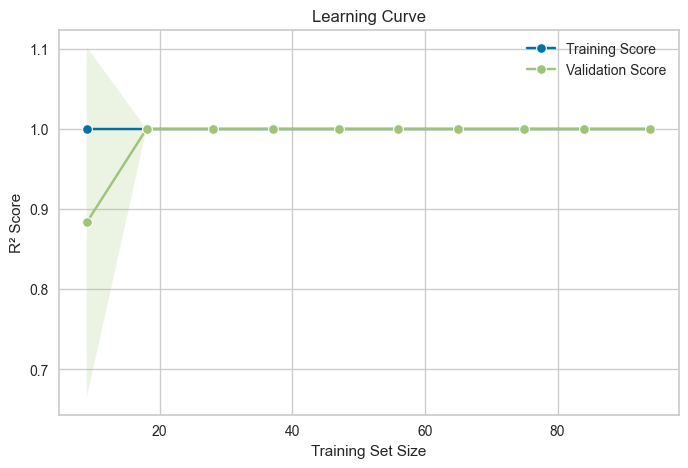

In [37]:

# Define model and data
model =md1  # Replace with your trained model
X = X_train  # Feature matrix
y = y_train  # Target variable

# Generate learning curve data
train_sizes, train_scores, test_scores = learning_curve(model, X, y, cv=5, scoring="r2", train_sizes=np.linspace(0.1, 1.0, 10))

# Compute mean and standard deviation
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

# Plot learning curve
plt.figure(figsize=(8, 5))
sns.lineplot(x=train_sizes, y=train_mean, label="Training Score", marker='o')
sns.lineplot(x=train_sizes, y=test_mean, label="Validation Score", marker='o')

# Fill the area between mean ± std
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.2)
plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, alpha=0.2)

plt.xlabel("Training Set Size")
plt.ylabel("R² Score")
plt.title("Learning Curve")
plt.legend()
plt.show()


## A Hyperparameter plot

{'copy_X': True, 'fit_intercept': True, 'n_jobs': -1, 'positive': False}


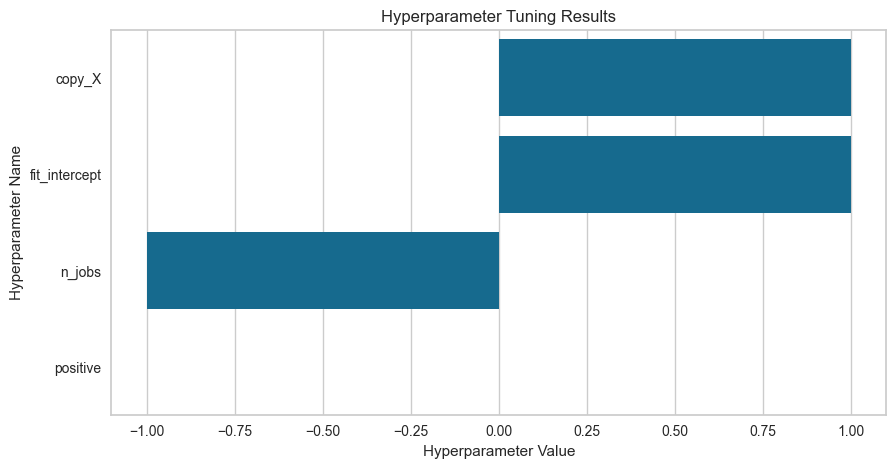

In [38]:
# Extract tuning results 
tuning_results = md1.get_params()  # Get hyperparameter values
print(tuning_results)  # Check available parameters

# Example: Convert results to a DataFrame (manually create if using GridSearchCV)
df = pd.DataFrame.from_dict(tuning_results, orient='index', columns=['Value']).reset_index()
df.columns = ['Hyperparameter', 'Value']

# Seaborn barplot for hyperparameter importance
plt.figure(figsize=(10, 5))
sns.barplot(x="Value", y="Hyperparameter", data=df)
plt.xlabel("Hyperparameter Value")
plt.ylabel("Hyperparameter Name")
plt.title("Hyperparameter Tuning Results")
plt.show()


## Findings /Summary

## Key Observations
The absolute differences and residuals are extremely small (close to zero), indicating an excellent fit of the model to the data.

The predicted values align almost perfectly with the actual values, suggesting that the model captures the relationship between production and emissions effectively.

No significant errors or deviations were observed in the predictions, which validates the accuracy of the regression model.


## Model Performance Metrics between Pycaret and Scikit-learn:
### The performance metrics for the Linear Regression model:

**MAE (Mean Absolute Error)**: 0.0564(Pycaret) & 0.0578(Scki-learn)

This value indicates the average absolute error between predicted and actual values. Since this value is low, it suggests that on average, the model's predictions are off by just apprx 0.0564 units.

**MSE (Mean Squared Error)**: 0.0061(Pycaret) & 0.0062(Scki-learn)

This indicates that the average squared error between the predicted and actual values is low. A smaller MSE means that the model is performing well in terms of minimizing large errors.

**RMSE (Root Mean Squared Error)**: 0.0780(Pycaret) & 0.0790(Scki-learn)

RMSE is a measure of the model's prediction error, with smaller values indicating better accuracy. In this case, the RMSE value is relatively low, which also suggests good predictive performance.

**R² (Coefficient of Determination)**: 1.0000(Pycaret) & 0.9999(Scki-learn)

This indicates a perfect fit. A value of 1 means that the model can explain 100% of the variance in the target variable, implying that the model fits the data extremely well.

**RMSLE (Root Mean Squared Logarithmic Error)**: 0.0199(Pycaret) & 0.0202(Scki-learn) 

This metric penalizes underestimations more than overestimations. The small value indicates that the model's logarithmic error is also quite low, suggesting a good fit.

**MAPE (Mean Absolute Percentage Error)**: 0.0106

This percentage error is very small, indicating that the model's predictions are almost identical to the actual values, with an average error of about 1.06%(Pycaret) & 1.08%(Scki-learn)


## Conclusion & Implications
Based on the findings, the Linear Regression Model is highly accurate in predicting total emissions (MtCO2e) from the production data. This suggests that: Production volume is a strong predictor of total emissions.

The model can be used for forecasting future emissions trends.

Organizations can rely on the model for emission reduction strategies and regulatory reporting.

Further analysis can explore the impact of different emission sources to optimize carbon management strategies.

This analysis provides a strong foundation for data-driven decision-making in emissions management and climate action initiatives.